In [1]:
import math
import copy
import random
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator


# neural network

In [2]:
def wgt(n):
    x = 0
    while x == 0:
        x = random.random() - .5
    x /= math.sqrt(n)*.5
    return x

def sigmoid(vals,weights):
    sig = sum([vals[i]*weights[i] for i in vals if i in weights])
    return 1/(1+math.e**(-1*sig))
def weighted_avg(vals,weights):
    sig = sum([vals[i]*weights[i] for i in vals if i in weights])
    return sig/len(weights)
class NE: #NE = net edge
    def __init__(self,start,end,weight):
        self.start = start
        self.end = end
        self.weight = weight
def runnet(nodes, edges, inpt,res):
    outputs = {}
    layer = nodes[0]
    res.append({})
    for k,node in layer.items():
        if k in edges[0]:
            outputs[k]= node(inpt,edges[0][k])
        elif k in inpt:
            outputs[k]= node(inpt[k])
        else:
            outputs[k] = node()
        res[-1][k] = outputs[k]
    if len(nodes) == 1:
        return res
    else:
        res = runnet(nodes[1:],edges[1:],outputs,res)
    return res

def errtool(res,tar,edges):
    errs = [{} for i in range(len(res))]
    for i in res[-1]:
        y = res[-1][i]
        t = tar[i] 
        errs[-1][i] =  y*(1-y)*(t-y)
    for i in range(len(res)-2,0,-1):
        for k in res[i]:  
            tot = 0
            hi = res[i][k]
            errs[i][k] = hi*(1-hi)*sum([edges[i+1][k2][k]*errs[i+1][k2] for k2 in edges[i+1] if k in edges[i+1][k2]])
    return errs
def learn(edges,n,errs,res):
    outedge = copy.deepcopy(edges)
    for i in range(len(outedge)-1):
        for outk in outedge[i+1]:
            for ink in outedge[i+1][outk]:
                try:
                    outedge[i+1][outk][ink] += n*errs[i+1][outk]*res[i][ink]
                except KeyError:
                    pass
    return outedge
def read_file(fnm):
    dataset = []
    with open(fnm,'r') as f:
        fs = f.read()
        for line in fs.split('\n'):
            if len(line.split(' ')) < 30:
                continue
            dataset.append({'data':{'ipt%d'%i:int(j)/16 for i,j in enumerate(line.split(' ')[:-1])}, 'target':int(line.split(' ')[-1])})
    return dataset
def make_plot(succ_rates):
    ax = plt.figure().gca()
    plt.scatter([i for i in range(1,len(succ_rates)+1)],succ_rates)
    plt.ylabel('success rate')
    plt.xlabel('number of training iterations')
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.show()
    print(succ_rates)

# worksheet example

In [ ]:
nodes = [
    {
    'I1':lambda x: x,
    'I2':lambda x: x,
    'b0': lambda: 1
    },
    {
        'h1':sigmoid,
        'h2':sigmoid,
        'b1': lambda: 1
    },
    {
        'y': sigmoid
    }
]
edges = [
    {},
    {'h1':{'b0':1,'I1':1,'I2':0.5},'h2':{'b0':1,'I1':-1,'I2':2}},
    {'y':{'b1':1,'h1':1.5,'h2':-1}}
]
inputs = {'I1':0,'I2':1}
tar = {'y':1}

print(edges)
res = runnet(nodes,edges,inputs,[])
print(res)
errs = errtool(res,tar,edges)
print(errs)
nedges = learn(edges,0.5,errs,res)
print(nedges)

# fishing data

In [ ]:
fishdat = []
testinpt = {}
with open('fishingNN.data','r') as f:
    fstr = f.read()
    last = False
    for line in fstr.split('\n'):
        if line == "":
            last = True
            continue
        elif last:
            ls = line.split(',')
            testinpt['wind'] = ls[0]
            testinpt['water'] = ls[1]
            testinpt['air'] = ls[2]
            testinpt['forecast'] = ls[3]
        else:
            ls = line.split(',')
            nn = {}
            nn['wind'] = ls[0]
            nn['water'] = ls[1]
            nn['air'] = ls[2]
            nn['forecast'] = ls[3]
            nn['target'] = ls[4]
            fishdat.append(nn)
"""
Training instances: 14
• Test sample: 1 (included in dataset)
• Categorical data w/4 attributes:
- Wind: Strong, Weak
- Water temp: Warm, Moderate, Cold
- Air temp: Warm, Cool
- Forecast: Sunny, Cloudy, Rainy
• Target: Yes/No
"""
vals = {
    'wind':['Strong','Weak'],
    'water':['Warm', 'Moderate', 'Cold'],
    'air':['Warm',"Cool"],
    'forecast':['Sunny','Cloudy','Rainy']
}
nodes = [{}]
for i in vals:
    for j in vals[i]:
        nodes[0][i+'-'+j] = lambda x: x
nodes.append({i:sigmoid for i in vals})
nodes.append({'yes': sigmoid,'no':sigmoid})


#learn
allerr = []
for j in range(10):
    lasterr = -1
    lasterr2 = -1
    edges = [
        {},
        {i:{i+'-'+j:(random.random()*-0.5)*2/math.sqrt(len(vals)) or (random.random()*-0.5)*2/math.sqrt(len(vals)) for j in vals[i]} for i in vals}
    ]
    edges.append({yn:{i:(random.random()*-0.5)*2/math.sqrt(2) or (random.random()*-0.5)*2/math.sqrt(2) for i in edges[1]} for yn in ['yes','no']})
    for i in range(100):
        itrerr = 0
        for row in fishdat:
            inputs = {}
            for j in vals:
                for k in vals[j]:
                    inputs[j+'-'+k] = 1 if row[j] == k else -1
            tar = ({'yes':1,'no':0} if row['target'] == 'Yes' else {'yes':0,'no':1})
            res = runnet(nodes,edges,inputs,[])
            errs = errtool(res,tar,edges)
            edges = learn(copy.deepcopy(edges),0.05,errs,res)
            itrerr += sum([errs[-1][j] for j in errs[-1]])
        print(itrerr)
        if itrerr == lasterr and lasterr == lasterr2: #if the last 3 runs have produced the same error, I can probably stop
            break
        else:
            lasterr2 = lasterr
            lasterr = itrerr
        
    allerr.append({'edges':edges,'err':itrerr})



In [ ]:
best = []
inputs = {}
for j in vals:
    for k in vals[j]:
        inputs[j+'-'+k] = 1 if testinpt[j] == k else -1
for i in allerr:
        if(i['err'] == min([j['err'] for j in allerr])):
            best = i['edges']

res = runnet(nodes,best,inputs,[])
res

# character recignition

### no hidden layers

In [3]:
dataset = read_file('digits-training.data')
nodes = [
    {'ipt'+str(i):lambda x: x for i in range(len(dataset[0]['data']))}
]   
nodes.append({'y%d'%i:sigmoid for i in range(10)})
succ_rates = []
test_edges = []
for its in range(1,13):
    edges = [{}] 
    edges.append({i:{j:wgt(len(nodes[-2])) for j in nodes[-2]} for i in nodes[-1]})
    for iteration in range(its):
        itrerr = 0
        for row in dataset:
            inputs = row['data']
            tar = row['target']
            res= runnet(nodes,edges,inputs,[])
            tar = {j:1 if i==tar else 0 for i,j in enumerate(nodes[-1].keys())}
            errs = errtool(res,tar,edges)
            edges = learn(copy.deepcopy(edges),0.05,errs,res)
            itrerr += sum(errs[-1].values())
            test = True
    test_edges.append(copy.deepcopy(edges))
    print('done with %d'%its)
print('done traingin')
succ_rates = []
dataset = read_file('digits-test.data')
for its,edges in enumerate(test_edges):
    right = 0
    tot = 0
    for row in dataset:
        inputs = row['data']
        tar = row['target']
        res= runnet(nodes,edges,inputs,[])
        guess = sum([int(i.replace('y','')) if j == max(res[-1].values()) else 0 for i,j in res[-1].items()])
        if tar == guess:
            right+=1
        tot += 1
    succ_rates.append(right/tot)
print(succ_rates)
make_plot(succ_rates)

done with 1
done with 2
done with 3
done with 4
done with 5
done with 6
done with 7
done with 8
done with 9
done with 10
done with 11
done with 12
done traingin
[0.904284919309961, 0.9176405119643851, 0.9232053422370617, 0.9254312743461325, 0.9287701725097385, 0.9276572064552031, 0.9315525876460768, 0.9315525876460768, 0.9326655537006121, 0.9343350027824151, 0.9332220367278798, 0.9348914858096828]


ValueError: x and y must be the same size

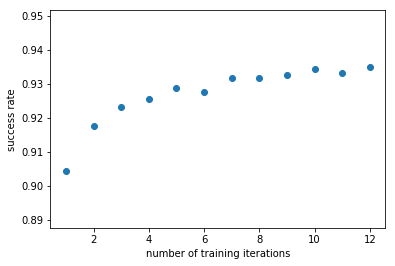

[0.904284919309961, 0.9176405119643851, 0.9232053422370617, 0.9254312743461325, 0.9287701725097385, 0.9276572064552031, 0.9315525876460768, 0.9315525876460768, 0.9326655537006121, 0.9343350027824151, 0.9332220367278798, 0.9348914858096828]


In [6]:
make_plot(succ_rates)

### One hidden layer

done with 1
done with 2
done with 3
done with 4
done with 5
done with 6
done with 7
done with 8
done with 9
done with 10
done with 11
done with 12
done traingin
[0.22092376182526433, 0.676126878130217, 0.8703394546466333, 0.9053978853644964, 0.9204229271007234, 0.9287701725097385, 0.9259877573734001, 0.9337785197551475, 0.9398998330550918, 0.9410127991096272, 0.9415692821368948, 0.9437952142459655]


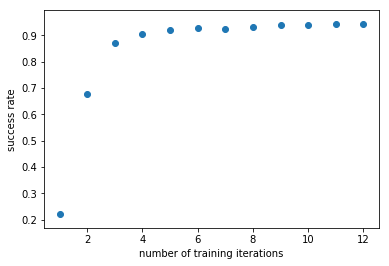

[0.22092376182526433, 0.676126878130217, 0.8703394546466333, 0.9053978853644964, 0.9204229271007234, 0.9287701725097385, 0.9259877573734001, 0.9337785197551475, 0.9398998330550918, 0.9410127991096272, 0.9415692821368948, 0.9437952142459655]


In [7]:
dataset = read_file('digits-training.data')
nodes = [
    {'ipt'+str(i):lambda x: x for i in range(len(dataset[0]['data']))}
]   
ls = lambda x,y: int((x+y)*(2/3))
nodes.append({'h%d'%i:sigmoid for i in range(ls(10,64))})
nodes.append({'y%d'%i:sigmoid for i in range(10)})
succ_rates = []
test_edges = []
for its in range(1,13):
    edges = [{}] 
    
    for i in range(len(nodes)-2):
        bigkeys = list(nodes[i+1])
        lilkeys = list(nodes[i])
        #edges.append({bigkeys[j]:{lilkeys[2*j]:wgt(len(nodes[i])),lilkeys[2*j+1]:wgt(len(nodes[i]))} for j in range(len(nodes[i+1]))})
        edges.append({j:{k:wgt(len(nodes[i])) for k in nodes[i]} for j in nodes[i+1]})
    edges.append({i:{j:wgt(len(nodes[-2])) for j in nodes[-2]} for i in nodes[-1]})
    for iteration in range(its):
        itrerr = 0
        for row in dataset:
            inputs = row['data']
            tar = row['target']
            res= runnet(nodes,edges,inputs,[])
            tar = {j:1 if i==tar else 0 for i,j in enumerate(nodes[-1].keys())}
            errs = errtool(res,tar,edges)
            edges = learn(copy.deepcopy(edges),0.05,errs,res)
            itrerr += sum(errs[-1].values())
            test = True
    test_edges.append(copy.deepcopy(edges))
    print('done with %d'%its)
print('done traingin')
succ_rates = []
dataset = read_file('digits-test.data')
for its,edges in enumerate(test_edges):
    right = 0
    tot = 0
    for row in dataset:
        inputs = row['data']
        tar = row['target']
        res= runnet(nodes,edges,inputs,[])
        guess = sum([int(i.replace('y','')) if j == max(res[-1].values()) else 0 for i,j in res[-1].items()])
        if tar == guess:
            right+=1
        tot += 1
    succ_rates.append(right/tot)
print(succ_rates)
make_plot(succ_rates)

### adjacency

done with 1
done with 2
done with 3
done with 4
done with 5
done with 6
done with 7
done with 8
done with 9
done with 10
done with 11
done with 12
done traingin
[0.1407902058987201, 0.5681691708402894, 0.7857540345019477, 0.8948247078464107, 0.9165275459098498, 0.9265442404006677, 0.9298831385642737, 0.9304396215915415, 0.9354479688369505, 0.9410127991096272, 0.9432387312186978, 0.9437952142459655]


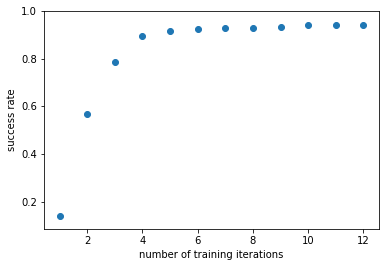

[0.1407902058987201, 0.5681691708402894, 0.7857540345019477, 0.8948247078464107, 0.9165275459098498, 0.9265442404006677, 0.9298831385642737, 0.9304396215915415, 0.9354479688369505, 0.9410127991096272, 0.9432387312186978, 0.9437952142459655]


In [12]:
dataset = read_file('digits-training.data')
nodes = [
    {'ipt'+str(i):lambda x: x for i in range(len(dataset[0]['data']))}
]   
midnodes = {}
for i in range(8):
    for j in range(7):
        midnodes['lr%d-%d'%(i,j)] = weighted_avg
for i in range(7):
    for j in range(8):
        midnodes['ud%d-%d'%(i,j)] = weighted_avg
for i in range(int((64+10)*(2/3))):
    midnodes['h%d'%i] = sigmoid
nodes.append(midnodes)
nodes.append({'y%d'%i:sigmoid for i in range(10)})
succ_rates = []
test_edges = []
for its in range(1,13):
    edges = [{}] 
    edges.append({})
    for i in range(int((64+10)*(2/3))):
        edges[-1]['h%d'%i] = {j:wgt(len(nodes[0])) for j in nodes[0]}
    for i in range(8):
        for j in range(7):
            edges[-1]['lr%d-%d'%(i,j)] = {'ipt%d'%(i*8+j):wgt(len(nodes[0])),'ipt%d'%(i*8+j+1):wgt(len(nodes[0]))}
    for i in range(7):
        for j in range(8):
            edges[-1]['ud%d-%d'%(i,j)] = {'ipt%d'%(i*8+j):wgt(len(nodes[0])),'ipt%d'%((i+1)*8+j):wgt(len(nodes[0]))}
    
    edges.append({i:{j:wgt(len(nodes[-2])) for j in nodes[-2]} for i in nodes[-1]})
    for iteration in range(its):
        itrerr = 0
        for row in dataset:
            inputs = row['data']
            tar = row['target']
            res= runnet(nodes,edges,inputs,[])
            tar = {j:1 if i==tar else 0 for i,j in enumerate(nodes[-1].keys())}
            errs = errtool(res,tar,edges)
            edges = learn(copy.deepcopy(edges),0.05,errs,res)
            itrerr += sum(errs[-1].values())
            test = True
    test_edges.append(copy.deepcopy(edges))
    print('done with %d'%its)
print('done traingin')
succ_rates = []
dataset = read_file('digits-test.data')
for its,edges in enumerate(test_edges):
    right = 0
    tot = 0
    for row in dataset:
        inputs = row['data']
        tar = row['target']
        res= runnet(nodes,edges,inputs,[])
        guess = sum([int(i.replace('y','')) if j == max(res[-1].values()) else 0 for i,j in res[-1].items()])
        if tar == guess:
            right+=1
        tot += 1
    succ_rates.append(right/tot)
print(succ_rates)
make_plot(succ_rates)

### multiple node configurations

In [11]:
dataset = read_file('digits-training.data')
succ_rates = []
test_edges = []
test_nodes = []
nodes = [
    {'ipt'+str(i):lambda x: x for i in range(len(dataset[0]['data']))}
] 

nodes.append({'h0%d'%i:sigmoid for i in range(64)})
nodes.append({'h1%d'%i:sigmoid for i in range(64)})
nodes.append({'y%d'%i:sigmoid for i in range(10)})
edges = [{}] 
edges.append({j:{k:wgt(len(nodes[0])) for k in nodes[0]} for j in nodes[1]})
edges.append({j:{k:wgt(len(nodes[1])) for k in nodes[1]} for j in nodes[2]})
edges.append({i:{j:wgt(len(nodes[-2])) for j in nodes[-2]} for i in nodes[-1]})
for its in range(25):
    hid_errs = [{k:0 for k in nodes[1]},{k:0 for k in nodes[2]}]
    for iteration in range(8):
        itrerr = 0
        for row in dataset:
            inputs = row['data']
            tar = row['target']
            res= runnet(nodes,edges,inputs,[])
            tar = {j:1 if i==tar else 0 for i,j in enumerate(nodes[-1].keys())}
            errs = errtool(res,tar,edges)
            for k in errs[1]:
                hid_errs[0][k] += errs[1][k]
            for k in errs[2]:
                hid_errs[1][k] += errs[2][k]
            edges = learn(copy.deepcopy(edges),0.05,errs,res)
            itrerr += sum(errs[-1].values())
            test = True
    test_edges.append(copy.deepcopy(edges))
    test_nodes.append(copy.deepcopy(nodes))
    try:
        maxe = [max(hid_errs[i].values()) for i in range(len(hid_errs))]
    except ValueError:
        break
    
    todel = [[],[]]
    for i,j in enumerate(hid_errs):
        for k in j:
            if hid_errs[i][k]/maxe[i] > random.random()*.75:
                todel[i].append(k)
    for i,j in enumerate(todel):
        if its > 5 or i <1:
            for k in todel[i]:
                del nodes[i+1][k]
                del edges[i+1][k]
                for ed in edges[i+2]:
                    if k in edges[i+2][ed]:
                        del edges[i+2][ed][k]
    for k in edges[2]:
        if hid_errs[1][k]/maxe[1] < random.random()*.25:
            for k2 in hid_errs[0]:
                if hid_errs[0][k2]/maxe[0] < random.random()*.25:
                    if k2 not in edges[2][k]:
                        edges[2][k][k2] = wgt(len(edges[1]))
    
    print('done with %d'%its)
print('done traingin')


done with 0
done with 1
done with 2
done with 3
done with 4
done with 5
done with 6
done with 7
done with 8
done with 9
done with 10
done with 11
done with 12
done traingin


[0.6688925987757374, 0.899276572064552, 0.9309961046188091, 0.9415692821368948, 0.9476905954368392, 0.9521424596549806, 0.9510294936004452, 0.9476905954368392, 0.9476905954368392, 0.9437952142459655, 0.9376739009460211, 0.8970506399554814, 0.8464106844741235, 0.09682804674457429]


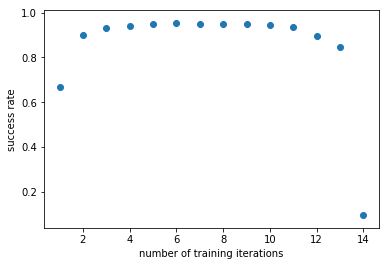

[0.6688925987757374, 0.899276572064552, 0.9309961046188091, 0.9415692821368948, 0.9476905954368392, 0.9521424596549806, 0.9510294936004452, 0.9476905954368392, 0.9476905954368392, 0.9437952142459655, 0.9376739009460211, 0.8970506399554814, 0.8464106844741235, 0.09682804674457429]


In [12]:
succ_rates = []
dataset = read_file('digits-test.data')
for its,edges in enumerate(test_edges):
    right = 0
    tot = 0
    for row in dataset:
        inputs = row['data']
        tar = row['target']
        res= runnet(test_nodes[its],test_edges[its],inputs,[])
        guess = sum([int(i.replace('y','')) if j == max(res[-1].values()) else 0 for i,j in res[-1].items()])
        if tar == guess:
            right+=1
        tot += 1
    succ_rates.append(right/tot)
print(succ_rates)
make_plot(succ_rates)

In [18]:
len(test_nodes[7][1])

13

In [21]:
for i in succ_rates:
    print("%.1f%%"%(i*100))

66.9%
89.9%
93.1%
94.2%
94.8%
95.2%
95.1%
94.8%
94.8%
94.4%
93.8%
89.7%
84.6%
9.7%
